# Growing Neural Cellular Automata for faces

## Imports and Notebook Utilities

In [14]:
import os
import pickle
from functools import partial

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
from flax.core.frozen_dict import freeze, unfreeze
from flax import traverse_util, serialization
import optax
import dm_pix as pix

import PIL.Image as pil
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from IPython.display import Image, HTML, clear_output
import tqdm

## Parameters

In [15]:
IMG_DIR = "/project/input/img_align_celeba/"
IMG_SIZE = 32

# VAE
NUM_FILTERS = 64
LATENT_SIZE = 256
LEARNING_RATE = 1e-3

# NCA
GENOTYPE_SIZE = 40 + 10
CHANNEL_SIZE = GENOTYPE_SIZE + 64
BATCH_SIZE = 32
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

EXPERIMENT_TYPE = "Persistent"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

## Variational Autoencoder

In [18]:
class Encoder(nn.Module):
	num_filters: int
	latent_size: int

	@nn.compact
	def __call__(self, x, train: bool):
		x = nn.relu(nn.Conv(features=self.num_filters, kernel_size=(5, 5), strides=(2, 2), padding="SAME")(x))
		x = nn.BatchNorm(use_running_average=not train)(x) # self.num_filters * 16 * 16

		x = nn.relu(nn.Conv(features=2*self.num_filters, kernel_size=(5, 5), strides=(2, 2), padding="SAME")(x))
		x = nn.BatchNorm(use_running_average=not train)(x) # 2 * self.num_filters * 8 * 8

		x = nn.relu(nn.Conv(features=4*self.num_filters, kernel_size=(5, 5), strides=(2, 2), padding="SAME")(x))
		x = nn.BatchNorm(use_running_average=not train)(x) # 4 * self.num_filters * 4 * 4

		x = x.reshape((x.shape[0], -1))
		mean = nn.Dense(self.latent_size)(x)
		log_var = nn.Dense(self.latent_size)(x)

		return mean, log_var

class Decoder(nn.Module):
	num_filters: int

	@nn.compact
	def __call__(self, z, train: bool):
		z = nn.relu(nn.Dense(4 * self.num_filters * 4 * 4)(z))
		z = z.reshape((z.shape[0], 4, 4, 4 * self.num_filters))
	
		z = nn.relu(nn.ConvTranspose(features=2*self.num_filters, kernel_size=(5, 5), strides=(2, 2), padding="SAME")(z))
		z = nn.BatchNorm(use_running_average=not train)(z) # 2 * self.num_filters * 8 * 8

		z = nn.relu(nn.ConvTranspose(features=self.num_filters, kernel_size=(5, 5), strides=(2, 2), padding="SAME")(z))
		z = nn.BatchNorm(use_running_average=not train)(z) # self.num_filters * 16 * 16

		z = nn.ConvTranspose(features=1, kernel_size=(5, 5), strides=(2, 2), padding="SAME")(z)
		z = nn.BatchNorm(use_running_average=not train)(z) # 1 * 32 * 32

		return z

class VAE(nn.Module):
	latent_size: int
	num_filters: int

	def setup(self):
		self.encoder = Encoder(self.latent_size, self.num_filters)
		self.decoder = Decoder(self.num_filters)

	def __call__(self, random_key, x, train):
		mean, log_var, z = self.encode(random_key, x, train)
		recon = self.decoder(z, train)
		return mean, log_var, recon

	def encode(self, random_key, x, train):
		mean, log_var = self.encoder(x, train)
		z = self.reparameterize(random_key, mean, log_var)
		return mean, log_var, z

	def decode(self, z):
		return self.decoder(z)

	def generate(self, z):
		return nn.sigmoid(self.decoder(z))

	def reparameterize(self, random_key, mean, log_var):
		std = jnp.exp(0.5 * log_var)
		return mean + std * jax.random.normal(random_key, log_var.shape)

random_key = jax.random.PRNGKey(0)
random_key, random_subkey_1, random_subkey_2 = jax.random.split(random_key, 3)
vae = VAE(latent_size=LATENT_SIZE, num_filters=NUM_FILTERS)
params = vae.init(random_subkey_1, random_subkey_2, jnp.ones((1, IMG_SIZE, IMG_SIZE, 1)), train=True)

state = TrainState.create(
	apply_fn=vae.apply,
	params=params,
	tx=optax.adam(LEARNING_RATE),
)

In [17]:
@jax.vmap
def kl_divergence(mean, log_var):
	return -0.5 * jnp.sum(1 + log_var - jnp.square(mean) - jnp.exp(log_var))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
	logits = nn.log_sigmoid(logits)
	return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))

In [ ]:
def compute_metrics(recon, x, mean, logvar):
	bce_loss = binary_cross_entropy_with_logits(recon, x).mean()
	kld_loss = kl_divergence(mean, logvar).mean()
	return {
		"bce": bce_loss,
		"kld": kld_loss,
		"loss": bce_loss + kld_loss}


def train_step(random_key, train_state, batch):

	def loss_fn(params):
		mean, log_var, recon = train_state.apply_fn(params, random_key, batch)

		bce_loss = binary_cross_entropy_with_logits(recon, batch).mean()
		kld_loss = kl_divergence(mean, log_var).mean()
		loss = bce_loss + kld_loss

		return loss

	grads = jax.grad(loss_fn)(train_state.params)
	return train_state.apply_gradients(grads=grads)

def eval_f(random_key, train_state, x, z):
	mean, log_var, recon = train_state.apply_fn(train_state.params, random_key, x)
	comparison = jnp.concatenate([x[:8].reshape(-1, IMG_SIZE, IMG_SIZE, 1), recon[:8].reshape(-1, IMG_SIZE, IMG_SIZE, 1)])

	generate_images = train_state.apply_fn(z, method=vae.generate)
	generate_images = generate_images.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
	metrics = compute_metrics(recon, x, mean, log_var)
	return metrics, comparison, generate_images

In [ ]:
random_key, random_subkey = jax.random.split(random_key, 2)

rng, z_key, eval_rng = random.split(rng, 3)
z = random.normal(z_key, (64, latents))

steps_per_epoch = ds_builder.info.splits["train"].num_examples // batch_size

for epoch in range(num_epochs):
for _ in range(steps_per_epoch):
batch = next(train_ds)
rng, key = random.split(rng)
state = train_step(state, batch, key, latents)

metrics, comparison, sample = eval_f(state.params, test_ds, z, eval_rng,
            latents)
vae_utils.save_image(
comparison, f'results/reconstruction_{epoch}.png', nrow=8)
vae_utils.save_image(sample, f'results/sample_{epoch}.png', nrow=8)

print('eval epoch: {}, loss: {:.4f}, BCE: {:.4f}, KLD: {:.4f}'.format(
epoch + 1, metrics['loss'], metrics['bce'], metrics['kld']
))

# Load dataset

## Attributes

In [3]:
# Load list_attr_celeba.txt file into a pandas DataFrame
df_attr_celeba = pd.read_csv("/project/input/annotations/list_attr_celeba.txt", sep="\s+", skiprows=1)
df_attr_celeba.replace(to_replace=-1, value=0, inplace=True) # replace -1 by 0

attr = jnp.array(df_attr_celeba)

## Landmarks

In [4]:
# Load list_landmarks_align_celeba.txt file into a pandas DataFrame
df_landmarks_align_celeba = pd.read_csv("/project/input/annotations/list_landmarks_align_celeba.txt", sep="\s+", skiprows=1)

# Normalize landmarks
df_landmarks_align_celeba["lefteye_y"] = df_landmarks_align_celeba["lefteye_y"] - 20
df_landmarks_align_celeba["righteye_y"] = df_landmarks_align_celeba["righteye_y"] - 20
df_landmarks_align_celeba["nose_y"] = df_landmarks_align_celeba["nose_y"] - 20
df_landmarks_align_celeba["leftmouth_y"] = df_landmarks_align_celeba["leftmouth_y"] - 20
df_landmarks_align_celeba["rightmouth_y"] = df_landmarks_align_celeba["rightmouth_y"] - 20

df_landmarks_align_celeba /= 178/IMG_SIZE

landmarks = jnp.array(df_landmarks_align_celeba)
landmarks = jax.nn.standardize(landmarks, axis=0)

## Create genotypes

In [5]:
genotypes = jnp.concatenate([attr, landmarks], axis=-1)

## Load images

In [6]:
def get_img(img_path) -> jnp.ndarray:
	img = pil.open(img_path).convert("L")
	img = jnp.expand_dims(jnp.array(img, dtype=np.float32), axis=-1) / 255.
	img = pix.resize_with_crop_or_pad(img, 178, 178)
	img = jax.image.resize(img, (IMG_SIZE, IMG_SIZE, 1), method="linear")
	return img

def standardize(imgs: jnp.ndarray) -> jnp.ndarray:
	imgs_mean = jnp.mean(imgs, axis=(1, 2))
	imgs_std = jnp.std(imgs, axis=(1, 2))
	imgs_standardized = (imgs - imgs_mean[:, None, None]) / imgs_std[:, None, None]
	return imgs_standardized, imgs_mean, imgs_std

def unstandardize(imgs_standardized: jnp.ndarray, imgs_mean: jnp.ndarray, imgs_std: jnp.ndarray) -> jnp.ndarray:
	return imgs_mean[:, None, None] + imgs_std[:, None, None] * imgs_standardized

def jnp2pil(img):
	img = img[:, :, 0]
	img = pil.fromarray(np.asarray(img * 255.).astype(np.uint8), "L")
	return img

def imshow(img: jnp.ndarray) -> None:
	"""Shows the input image using PIL/Pillow backend."""
	img = jnp2pil(img)
	display(img)

def imwrite(f, a, fmt=None):
	a = np.asarray(a)
	if isinstance(f, str):
		fmt = f.rsplit(".", 1)[-1].lower()
		if fmt == "jpg":
			fmt = "jpeg"
		f = open(f, "wb")
	jnp2pil(a).save(f, fmt, quality=95)

def tile2d(a, w=None):
	a = np.asarray(a)
	if w is None:
		w = int(np.ceil(np.sqrt(len(a))))
	th, tw = a.shape[1:3]
	pad = (w-len(a))%w
	a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), "constant")
	h = len(a)//w
	a = a.reshape([h, w]+list(a.shape[1:]))
	a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
	return a

def zoom(img, scale=4):
	img = np.repeat(img, scale, 0)
	img = np.repeat(img, scale, 1)
	return img

class VideoWriter:
	def __init__(self, filename, fps=30.0, **kw):
		self.writer = None
		self.params = dict(filename=filename, fps=fps, **kw)

	def add(self, img):
		img = np.asarray(img)
		if self.writer is None:
			h, w = img.shape[:2]
			self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
		if img.dtype in [np.float32, np.float64]:
			img = np.uint8(img.clip(0, 1)*255)
		if len(img.shape) == 2:
			img = np.repeat(img[..., None], 3, -1)
		self.writer.write_frame(img)

	def close(self):
		if self.writer:
			self.writer.close()

	def __enter__(self):
		return self

	def __exit__(self, *kw):
		self.close()

In [7]:
imgs = []
for index, row in tqdm.tqdm(df_attr_celeba.iterrows(), total=df_attr_celeba.shape[0]):
	imgs.append(get_img(IMG_DIR + index))
imgs = jnp.stack(imgs)

100%|██████████| 202599/202599 [03:43<00:00, 906.02it/s] 


In [8]:
imgs_standardized, imgs_mean, imgs_std = imgs, jnp.zeros((imgs.shape[0], 1)), jnp.ones((imgs.shape[0], 1))

In [9]:
imgs_standardized, imgs_mean, imgs_std = standardize(imgs)

In [10]:
imgs_standardized, imgs_mean, imgs_std = imgs_standardized[:3], imgs_mean[:3], imgs_std[:3]

## CA Model and Utilities

In [11]:
def to_grey_alpha(x):
	return x[..., :2]

def to_alpha(x):
	return jnp.clip(x[..., 1:2], a_min=0.0, a_max=1.0)

def to_grey(x):
	# assume rgb premultiplied by alpha
	rgb, a = x[..., :1], to_alpha(x)
	return 1.0-a+rgb

@jax.jit
def get_living_mask(x):
	alpha = x[..., 1:2]
	return nn.max_pool(alpha, window_shape=(3, 3), strides=(1, 1), padding="SAME") > 0.1

@partial(jax.jit)
def make_seed(genotype):
	x = jnp.zeros((IMG_SIZE, IMG_SIZE, CHANNEL_SIZE))
	x = x.at[IMG_SIZE//2, IMG_SIZE//2, 1:].set(1.0)
	return x.at[IMG_SIZE//2, IMG_SIZE//2, -genotype.shape[0]:].set(genotype)

class CAModel(nn.Module):
	channel_size = CHANNEL_SIZE
	fire_rate = CELL_FIRE_RATE

	@nn.compact
	def __call__(self, random_key, x, step_size=1.0):
		pre_life_mask = get_living_mask(x)

		# Perceive with depthwise convolution
		y = nn.Conv(features=3*x.shape[-1], kernel_size=(3, 3), padding="SAME", feature_group_count=x.shape[-1], use_bias=False, name="perceive")(x)

		# Update
		dx = nn.relu(nn.Conv(features=256, kernel_size=(1, 1))(y))
		dx = nn.Conv(features=self.channel_size, kernel_size=(1, 1), kernel_init=nn.initializers.zeros)(dx) * step_size
		update_mask = jax.random.uniform(random_key, shape=(*x.shape[:-1], 1), minval=0., maxval=1.) <= self.fire_rate
		x += dx * update_mask

		post_life_mask = get_living_mask(x)
		life_mask = pre_life_mask & post_life_mask
		return x * life_mask

	@partial(jax.jit, static_argnames=("self",))
	def _get_kernel(self, angle=0.):
		identify = jnp.array([0., 1., 0.])
		identify = jnp.outer(identify, identify)
		dx = jnp.outer(jnp.array([1., 2., 1.]), jnp.array([-1., 0., 1.])) / 8.0  # Sobel filter
		dy = dx.T
		c, s = jnp.cos(angle), jnp.sin(angle)
		kernel = jnp.stack([identify, c*dx-s*dy, s*dx+c*dy], axis=-1)[:, :, None, :]
		kernel = jnp.tile(kernel, (1, 1, 1, self.channel_size))
		return kernel

	def set_kernel(self, params, angle=0.):
		kernel = self._get_kernel(angle)
		params = unfreeze(params)
		params["params"]["perceive"]["kernel"] = kernel
		params = freeze(params)
		return params

	def get_mask(self, params):
		flat_params = traverse_util.flatten_dict(params, sep="/")
		flat_params = dict.fromkeys(flat_params, False)

		for key in flat_params:
			if "perceive" in key:
				flat_params[key] = True
		return freeze(traverse_util.unflatten_dict(flat_params, sep="/"))

# Training

## Train Utilities (SamplePool, Model Export, Damage)

In [12]:
class SamplePool(flax.struct.PyTreeNode):
	indices: jnp.ndarray
	samples: jnp.ndarray
	targets: jnp.ndarray

	@classmethod
	def init(cls, random_key):
		indices = jax.random.randint(random_key, (POOL_SIZE,), minval=0, maxval=imgs_standardized.shape[0])
		seeds = jax.vmap(make_seed)(genotypes[indices])
		targets = jnp.take(imgs_standardized, indices, axis=0)
		return cls(indices=indices, samples=seeds, targets=targets)

	@partial(jax.jit, static_argnames=("batch_size",))
	def sample(self, random_key, batch_size):
		idx = jax.random.choice(random_key, POOL_SIZE, shape=(batch_size,), replace=False)
		indices = jnp.take(self.indices, idx, axis=0)
		samples = jnp.take(self.samples, idx, axis=0)
		targets = jnp.take(self.targets, idx, axis=0)
		return idx, indices, samples, targets

	@jax.jit
	def commit(self, idx, indices, samples, targets):
		indices = self.indices.at[idx].set(indices)
		samples = self.samples.at[idx].set(samples)
		targets = self.targets.at[idx].set(targets)
		return self.replace(indices=indices, samples=samples, targets=targets)

def make_circle_masks(random_key, n, h, w):
	x = jnp.linspace(-1.0, 1.0, w)[None, None, :]
	y = jnp.linspace(-1.0, 1.0, h)[None, :, None]
	random_key_1, random_key_2 = jax.random.split(random_key)
	center = jax.random.uniform(random_key_1, shape=(2, n, 1, 1), minval=-0.5, maxval=0.5)
	r = jax.random.uniform(random_key_2, shape=(n, 1, 1), minval=0.1, maxval=0.4)
	x, y = (x-center[0])/r, (y-center[1])/r
	mask = x*x+y*y < 1.0
	return mask

def export_model(params, base_fn):
    state_dict = serialization.to_state_dict(params)
    with open(base_fn, "wb") as params_file:
        pickle.dump(state_dict, params_file)

def generate_pool_figures(pool, step_i):
	indices = pool.indices[:49]
	samples = pool.samples[:49]
	tiled_pool = tile2d(to_grey(unstandardize(samples, imgs_mean[indices], imgs_std[indices])))
	fade = np.linspace(1.0, 0.0, 72)
	ones = np.ones(72)
	tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None]
	tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
	tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
	tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
	imwrite("/project/output/train_log/%04d_pool.jpg"%step_i, tiled_pool)

def visualize_batch(samples, samples_, targets, step_i):
	vis0 = np.hstack(np.array(to_grey(samples)))
	vis1 = np.hstack(np.array(to_grey(samples_)))
	vis2 = np.hstack(np.array(targets))
	vis = np.vstack([vis0, vis1, vis2])
	imwrite("/project/output/train_log/batches_%04d.jpg"%step_i, vis)
	imshow(vis)

def plot_loss(loss_log):
	pl.figure(figsize=(10, 4))
	pl.title("Loss history (log10)")
	pl.plot(np.log10(loss_log), ".", alpha=0.1)
	pl.show()

## Initialize Training

In [13]:
random_key = jax.random.PRNGKey(42)

genotype = genotypes[0]
img = imgs_standardized[0]
seed = make_seed(genotype)

def loss_f(prediction, target):
	return jnp.mean(jnp.square(to_grey_alpha(prediction) - jnp.concatenate([target, jnp.ones_like(target)], axis=-1)), axis=(-1, -2, -3))

ca = CAModel()
random_key, random_subkey_1, random_subkey_2 = jax.random.split(random_key, 3)
params = ca.init(random_subkey_1, random_subkey_2, seed)
params = ca.set_kernel(params)

loss_log = []

lr = 2e-3
lr_sched = optax.linear_schedule(init_value=lr, end_value=0.1*lr, transition_steps=2000)
trainer = optax.adam(learning_rate=lr_sched)

# zero update
def zero_grads():
	def init_fn(_):
		return ()

	def update_fn(updates, state, params=None):
		return jax.jax.tree_util.tree_map(jnp.zeros_like, updates), ()
	return optax.GradientTransformation(init_fn, update_fn)

tx = optax.multi_transform({False: optax.adam(learning_rate=lr_sched),
			    			True: zero_grads()}, ca.get_mask(params))

train_state = TrainState.create(
	apply_fn=ca.apply,
	params=params,
	tx=tx)

loss0 = loss_f(seed, img)

random_key, random_subkey = jax.random.split(random_key)
pool = SamplePool.init(random_subkey)

!mkdir -p /project/output/train_log && rm -f /project/output/train_log/*

  label_set = set(jax.tree_leaves(labels))



## Training Loop

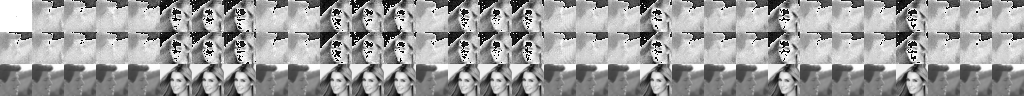

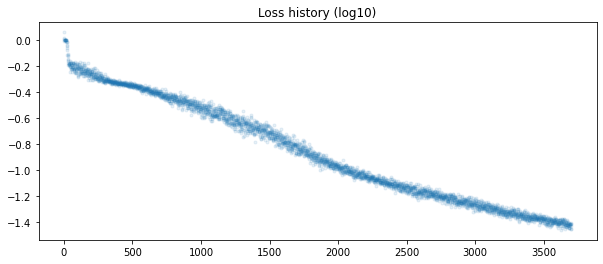

 step: 3800, log10(loss): -1.443

KeyboardInterrupt: 

In [14]:
@jax.jit
def scan_apply(carry, x):
	(params, batch,) = carry
	(random_key,) = x

	batch = train_state.apply_fn(params, random_key, batch)
	return (params, batch), ()

@partial(jax.jit, static_argnames=("iter_n",))
def train_step(random_key, train_state, batch, targets, iter_n):
	def loss_fn(params):
		random_keys = jax.random.split(random_key, iter_n)
		(params, predictions), _ = jax.lax.scan(
			scan_apply,
			(params, batch,),
			(random_keys,),
			length=iter_n)
		return loss_f(predictions, targets).mean(), predictions

	(loss, predictions), grads = jax.value_and_grad(loss_fn, has_aux=True)(train_state.params)
	train_state = train_state.apply_gradients(grads=grads)

	return train_state, loss, predictions

for i in range(8000+1):
	random_key, random_subkey_1, random_subkey_2, random_subkey_3, random_subkey_4, random_subkey_5 = jax.random.split(random_key, 6)

	if USE_PATTERN_POOL:
		idx, indices, samples, targets = pool.sample(random_subkey_1, BATCH_SIZE)
		loss_rank = jnp.flip(jnp.argsort(loss_f(samples, targets)))

		idx = jnp.take(idx, loss_rank, axis=0)
		indices = jnp.take(indices, loss_rank, axis=0)
		samples = jnp.take(samples, loss_rank, axis=0)
		targets = jnp.take(targets, loss_rank, axis=0)

		index = jax.random.randint(random_subkey_2, shape=(), minval=0, maxval=imgs_standardized.shape[0])
		indices = indices.at[0].set(index)
		samples = samples.at[0].set(make_seed(genotypes[index]))
		targets = targets.at[0].set(imgs_standardized[index])
		if DAMAGE_N:
			damage = 1.0-make_circle_masks(random_subkey_3, DAMAGE_N, IMG_SIZE, IMG_SIZE)[..., None]
			samples = samples.at[-DAMAGE_N:].set(samples[-DAMAGE_N:] * damage)
	else:
		samples = jnp.repeat(seed, repeats=BATCH_SIZE, axis=0)

	iter_n = jax.random.randint(random_subkey_4, shape=(), minval=64, maxval=96)
	train_state, loss, samples_ = train_step(random_subkey_5, train_state, samples, targets, int(iter_n))

	if USE_PATTERN_POOL:
		pool = pool.commit(idx, indices, samples_, targets)

	step_i = len(loss_log)
	loss_log.append(loss)

	if step_i % 10 == 0:
		generate_pool_figures(pool, step_i)
	if step_i % 100 == 0:
		clear_output()
		visualize_batch(
			unstandardize(samples, imgs_mean[indices], imgs_std[indices]),
			unstandardize(samples_, imgs_mean[indices], imgs_std[indices]),
			unstandardize(targets, imgs_mean[indices], imgs_std[indices]),
			step_i,)
		plot_loss(loss_log)
		export_model(train_state.params, "/project/output/train_log/%04d"%step_i)

	print("\r step: %d, log10(loss): %.3f"%(len(loss_log), np.log10(loss)), end="")